# Modeling MBSA dataset using Neural Network
 
This tutorial shows how to use **Neural Network** to model **Mouse Brain Sagittal Anterior** dataset, including the parameter tuning process. The resulting figures are saved in the figure folder.

## Content
* [Data preprocess](#data-preprocess)
  1. [Reading Visium data](#reading-visium-data)
  2. [Quality Control](#quality-control)
* [Making dataset](#making-dataset)
  1. [Label and feature](#label-and-feature)
  2. [Splitting dataset](#splitting-dataset)
* [Neural Network](#neural-network)
  1. [Tuning parameters](#tuning-parameters)
  2. [Final model](#final-model)

## Data preprocess

First, load packages.

In [1]:
import os
os.chdir("..")
import scanpy as sc
import numpy as np
import itertools

import datapre as DP
from model import nn_model
from model import hyper_opt as hop
import evaluation as eval

sc.set_figure_params(facecolor = "white")
sc.settings.verbosity = 1
dirname = "mouse_brain_sagittal_anterior"

Set the default **Cell Neighborhood Radius** to 1.0.

In [2]:
NEIGHBOR_DIS = 1.0

### Reading Visium data

Mark mitochondrial genes. Visualize using the `DP.feature_plot` function.

/home/huggs/anaconda3/envs/rapids_nwt/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


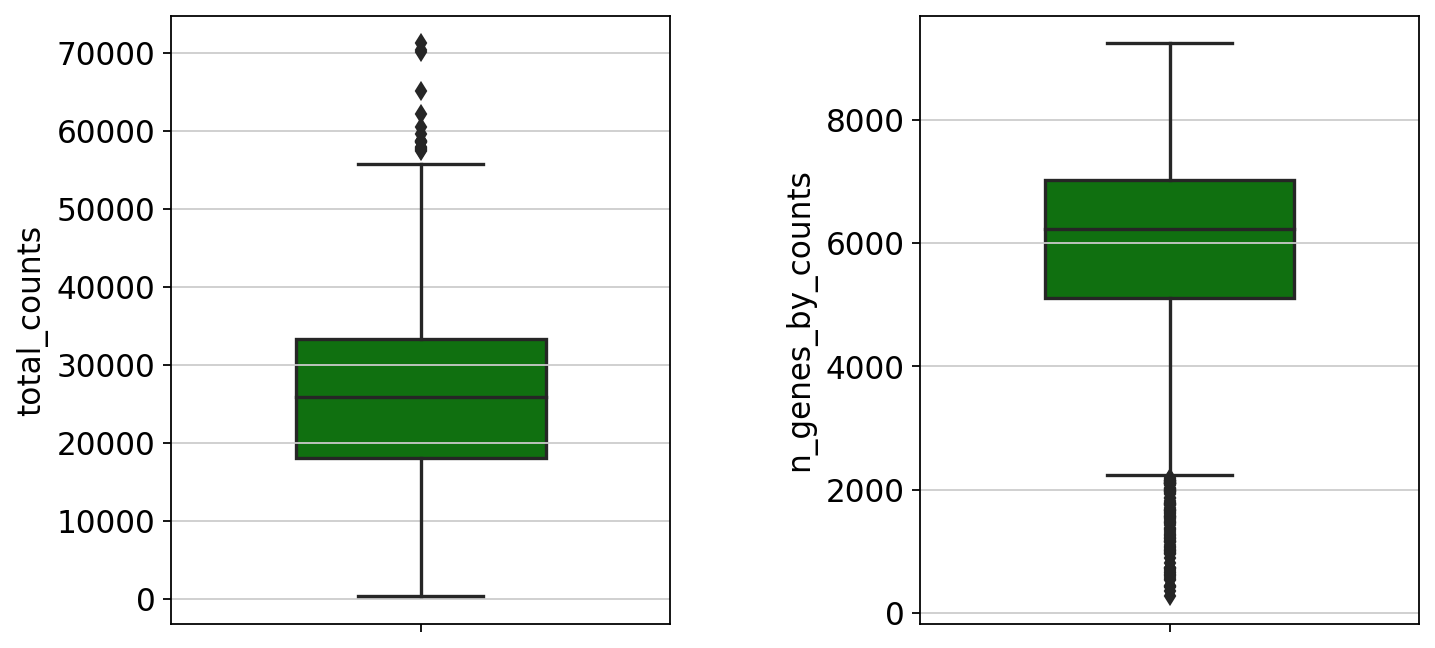

In [3]:
adata = sc.datasets.visium_sge(sample_id = "V1_Mouse_Brain_Sagittal_Anterior")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt"], inplace = True)
DP.feature_plot(adata)

### Quality Control

Filter genes with total expression less than 10. For other QC, you can refer to `DP.Filter` function.

In [4]:
sc.pp.filter_genes(adata, min_counts = 10)

## Making dataset

Globally set the seed.

In [5]:
DP.setup_seed(38)

Run [SpaGene.R](../spagene.R) to identify spatially variable genes.

In [6]:
DP.adata2seurat(adata, "V1_Mouse_Brain_Sagittal_Anterior")
! Rscript spagene.R V1_Mouse_Brain_Sagittal_Anterior 1000
spagene = DP.find_spa("data/V1_Mouse_Brain_Sagittal_Anterior/spagene.txt")

Loading required package: ggplot2
Loading required package: patchwork


In [8]:
train_feature, train_label, test_feature, test_label, _ = \
    DP.dataset(adata, spagene, neighbor_dis = NEIGHBOR_DIS, mirror = False)

test_index = test_feature[:, [0,1]].astype("int32")
test_feature = test_feature[:, 2:]

## Neural Network

### Tuning parameters

The hyperparameters that need to be optimized are:
- `num_features`
- `hidden_layer_sizes`
- `dropout_rate`
- `batch_size`

First, we conduct a random search to obtain a set of hyperparameters that perform well.

In [11]:
params_1 = {
    "num_features": range(100, 800, 100),
    "hidden_layer_sizes": list(itertools.product(range(200, 600, 100), (50, 100))),
    "dropout_rate": [0.0, 0.2, 0.5],
    "batch_size": [8, 16, 32, 64]
}
nnmodel_1 = nn_model.NeuralNetworkClassifier(verbose = False)
cv1 = hop.random_search(nnmodel_1, params_1, train_feature, train_label)

mean_score_time                                             0.170039
mean_test_loss                                             -0.181249
std_test_loss                                               0.012323
mean_test_auc                                                0.97374
std_test_auc                                                0.003001
rank_test_loss                                                     1
rank_test_auc                                                      2
params             {'num_features': 200, 'hidden_layer_sizes': (5...
Name: 5, dtype: object


In [12]:
cv1.best_params_

{'num_features': 200,
 'hidden_layer_sizes': (500, 100),
 'dropout_rate': 0.5,
 'batch_size': 32}

Second, optimize the hyperparameters one by one based on this set.

Grid search on `num_features`.

mean_score_time                 0.087222
mean_test_loss                 -0.172545
std_test_loss                   0.015477
mean_test_auc                   0.975637
std_test_auc                      0.0037
rank_test_loss                         1
rank_test_auc                          1
params             {'num_features': 200}
Name: 1, dtype: object


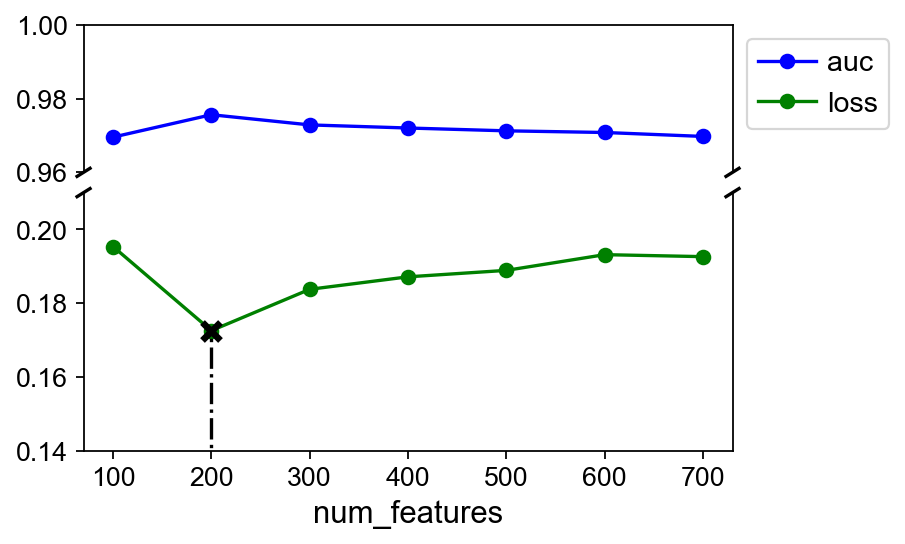

In [13]:
params_2 = {
    "num_features": range(100, 800, 100)
}
nnmodel_2 = nn_model.NeuralNetworkClassifier(
    verbose = False, 
    hidden_layer_sizes = cv1.best_params_["hidden_layer_sizes"], 
    dropout_rate = cv1.best_params_["dropout_rate"],
    batch_size = cv1.best_params_["batch_size"]
)
cv2 = hop.grid_search(nnmodel_2, params_2, train_feature, train_label, figname = dirname + "/figure/NN_num_features")

In [14]:
cv2.best_params_

{'num_features': 200}

Grid search on `batch_size`.

mean_score_time               0.067119
mean_test_loss               -0.168151
std_test_loss                 0.011049
mean_test_auc                 0.976101
std_test_auc                  0.002531
rank_test_loss                       1
rank_test_auc                        2
params             {'batch_size': 128}
Name: 4, dtype: object


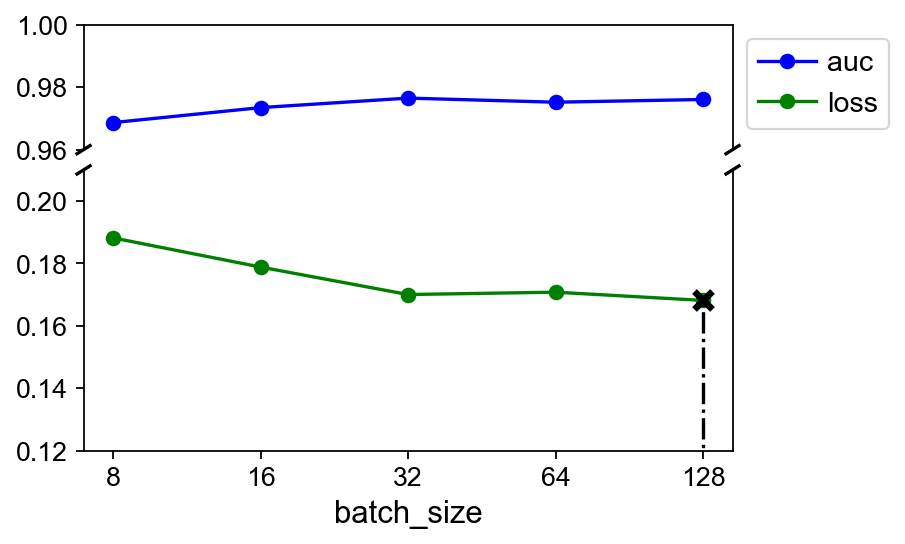

In [15]:
params_3 = {
    "batch_size": [8, 16, 32, 64, 128]
}
nnmodel_3 = nn_model.NeuralNetworkClassifier(
    verbose = False, 
    num_features = cv2.best_params_["num_features"], 
    hidden_layer_sizes = cv1.best_params_["hidden_layer_sizes"], 
    dropout_rate = cv1.best_params_["dropout_rate"]
)
cv3 = hop.grid_search(nnmodel_3, params_3, train_feature, train_label, figname = dirname + "/figure/NN_batch_size")

In [16]:
cv3.best_params_

{'batch_size': 128}

Grid search on `dropout_rate`.

mean_score_time                 0.066815
mean_test_loss                 -0.167184
std_test_loss                     0.0138
mean_test_auc                   0.976688
std_test_auc                    0.004172
rank_test_loss                         1
rank_test_auc                          1
params             {'dropout_rate': 0.5}
Name: 5, dtype: object


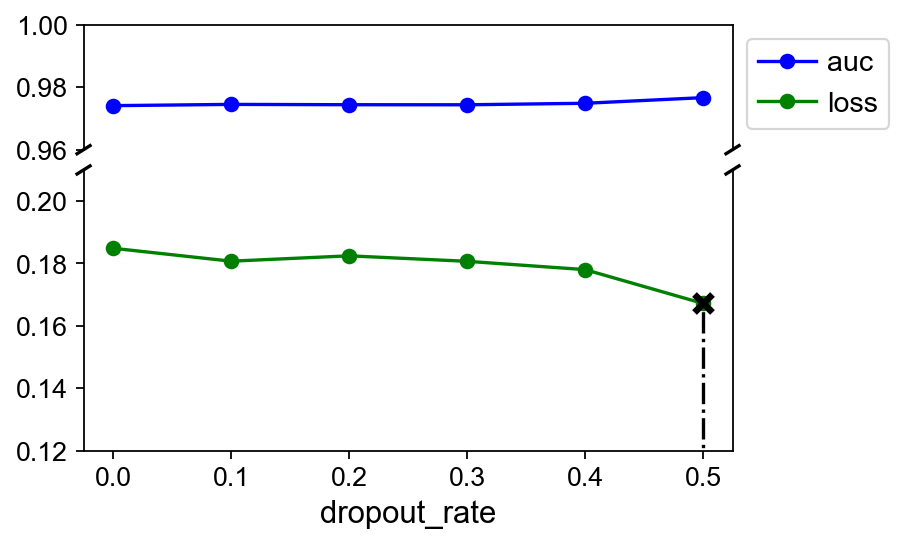

In [17]:
params_4 = {
    "dropout_rate": np.arange(0.0, 0.6, 0.1).round(1)
}
nnmodel_4 = nn_model.NeuralNetworkClassifier(
    verbose = False, 
    num_features = cv2.best_params_["num_features"], 
    batch_size = cv3.best_params_["batch_size"],
    hidden_layer_sizes = cv1.best_params_["hidden_layer_sizes"]
)
cv4 = hop.grid_search(nnmodel_4, params_4, train_feature, train_label, figname = dirname + "/figure/NN_dropout_rate")

In [18]:
cv4.best_params_

{'dropout_rate': 0.5}

### Final model

第0轮，训练损失：0.3677
第0轮，验证损失：0.2360
Validation loss decreased (inf --> 0.236013).  Saving model ...
第1轮，训练损失：0.2466
第1轮，验证损失：0.2119
Validation loss decreased (0.236013 --> 0.211944).  Saving model ...
第2轮，训练损失：0.2215
第2轮，验证损失：0.1913
Validation loss decreased (0.211944 --> 0.191349).  Saving model ...
第3轮，训练损失：0.1988
第3轮，验证损失：0.1804
Validation loss decreased (0.191349 --> 0.180351).  Saving model ...
第4轮，训练损失：0.1870
第4轮，验证损失：0.1798
Validation loss decreased (0.180351 --> 0.179806).  Saving model ...
第5轮，训练损失：0.1777
第5轮，验证损失：0.1711
Validation loss decreased (0.179806 --> 0.171065).  Saving model ...
第6轮，训练损失：0.1648
第6轮，验证损失：0.1692
Validation loss decreased (0.171065 --> 0.169162).  Saving model ...
第7轮，训练损失：0.1550
第7轮，验证损失：0.1662
Validation loss decreased (0.169162 --> 0.166153).  Saving model ...
第8轮，训练损失：0.1491
第8轮，验证损失：0.1863
EarlyStopping counter: 1 out of 7
第9轮，训练损失：0.1438
第9轮，验证损失：0.1596
Validation loss decreased (0.166153 --> 0.159587).  Saving model ...
第10轮，训练损失：0.1390
第10轮，验证损失：0.1

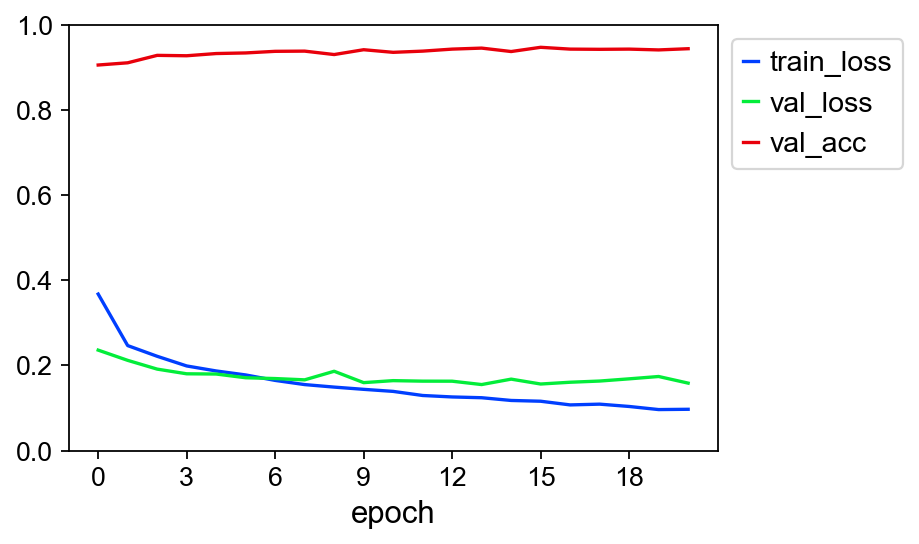

{'Accuracy': 0.9412515964240102,
 'Precision': 0.8668941979522184,
 'Recall': 0.9731800766283525,
 'MCC': 0.87523765665755,
 'F_Score': 0.9169675090252708,
 'AUC': 0.9797822991441699,
 'Average Precision': 0.9434015969155283,
 'confusion_matrix': array([[1449,  117],
        [  21,  762]], dtype=int64)}

In [19]:
nnmodel = nn_model.NeuralNetworkClassifier(
    num_features = 200, 
    batch_size = 128,
    hidden_layer_sizes = (500, 100),
    dropout_rate = 0.5,
    figname = dirname + "/figure/NN_epoch"
)
nnmodel.fit(train_feature, train_label)
pred = nnmodel.predict(test_feature)
predprob = nnmodel.predict_proba(test_feature)
eval.evaluate(test_label, pred, predprob, verbose = False)